**Подключение библиотек и скриптов**

In [16]:
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
matplotlib.rcParams.update({'font.size': 14})

In [19]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

**Описание датасета:**  

**Id** - идентификационный номер квартиры  
**DistrictId** - идентификационный номер района  
**Rooms** - количество комнат  
**Square** - площадь  
**LifeSquare** - жилая площадь   
**KitchenSquare** - площадь кухни    
**Floor** - этаж  
**HouseFloor** - количество этажей в доме  
**HouseYear** - год постройки дома  
**Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности  
**Social_1, Social_2, Social_3** - социальные показатели местности  
**Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья  
**Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров  
**Price** - цена квартиры  

### Загрузка данных

In [20]:
test_df = pd.read_csv('test.csv') # файл для предсказания

In [21]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 683.7+ KB


Есть пропуски в данных

In [22]:
train_df = pd.read_csv('train.csv') # тренировочный сет

In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.4+ MB


Также есть пропуски

*Сделаем Id строковой переменной*

In [24]:
test_df['Id'] = test_df['Id'].astype(str)
test_df['Id'].dtype

dtype('O')

In [25]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['Id'].dtype

dtype('O')

**Функции для очистки и подготовки данных**

In [26]:
def clean_life_square(df):
    df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'].median() # пропуски заполняем медианным зн-нием 
    df.loc[df['LifeSquare'] > 300, 'LifeSquare'] = df['LifeSquare'].median() # выбросы жилой площади больше 300 и меньне 10
    df.loc[(df['LifeSquare'] <= 10, 'LifeSquare')] = df['LifeSquare'].median()#  заменяем медианой

In [27]:
def clean_healthcare_1(df):
    df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()

In [28]:
def clean_square(df):
    df.loc[df['Square'] > 300, 'Square'] = df['Square'].median()
    df.loc[(df['Square'] < df['LifeSquare']), 'Square'] = df.loc[df['Square']< df['LifeSquare'], 'Square'] / 0.64 
    # Площадь квартиры, которая меньше жилой площади, делим на коэффиц. 0,64 (соотношение ср.значения площади кв. к
    # ср. зн-нию ср. жилой площади кв.)

In [29]:
def clean_rooms(df):
    df.loc[df['Rooms'] == 0, 'Rooms'] = df['Rooms'].median()

In [30]:
def clean_year(df):
    df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = 2008
    df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
    

In [31]:
def clean_housefloor(df):
    df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].median()

In [32]:
def clean_kitchenSquare(df):
    df.loc[df['KitchenSquare'] > 30, 'KitchenSquare'] = df['KitchenSquare'].median()
    df.loc[(df['Square'] < df['KitchenSquare']), 'KitchenSquare'] = df['KitchenSquare'].median()
    df.loc[(df['KitchenSquare'] < 5, 'KitchenSquare')] = df['KitchenSquare'].median()
    # Площать кухни, кот. больше площади квартиры, замен. на медиану. Аналогично для площади кухни меньше 5 кв. м

In [33]:
def prepare_data(df):
    clean_healthcare_1(df)
    clean_square(df)
    clean_rooms(df)
    clean_year(df)
    clean_housefloor(df)
    clean_life_square(df)
    clean_kitchenSquare(df)
   

### Отбор признаков

In [34]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [35]:
train_df.dtypes

Id                object
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [36]:
feature_names = ['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1'
 ]

target_name = 'Price'

In [37]:
train_df = train_df[feature_names + [target_name]]
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11,184966.930730
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644


### Стандартизация признаков

In [38]:
feature_names_for_stand = train_df[feature_names].select_dtypes(include='float64').columns.tolist()
feature_names_for_stand

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'HouseFloor',
 'Ecology_1',
 'Healthcare_1']

In [39]:
prepare_data(train_df) # применяем функцию для очистки данных

In [40]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(train_df[feature_names_for_stand])

In [41]:
train_df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [42]:
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,35,0.128794,-0.453729,-0.425150,-0.608862,7,-0.614468,1969,-0.250529,33,7976,5,-0.169240,0,11,184966.930730
1,41,1.322440,0.369245,0.264599,0.284618,7,-0.614468,1978,-0.998053,46,10309,1,-1.053217,1,16,300009.450063
2,53,0.128794,-0.594762,-0.441092,-0.608862,8,-0.148856,1968,-0.581588,34,7759,0,-1.067950,1,3,220925.908524
3,58,0.128794,-0.204010,1.089295,0.731358,8,0.627163,1977,2.680470,23,5735,3,0.077202,0,5,175616.227217
4,99,-1.064851,-0.841103,-0.793643,-0.162122,11,-0.148856,1976,-0.894969,35,5776,1,1.408526,2,4,150226.531644


### Разбиение на тренировочный и валидационный датасеты

In [43]:
X = train_df[feature_names]

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     10000 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
dtypes: float64(7), int64(8)
memory usage: 1.1 MB


In [44]:

y = train_df[target_name]

In [45]:
y.count()

10000

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=21)

### Построение базовых моделей и выбор лучшей

**Random Forest**

In [47]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

R2:	0.947
MAE:	12187.556
MSE:	451913031.298


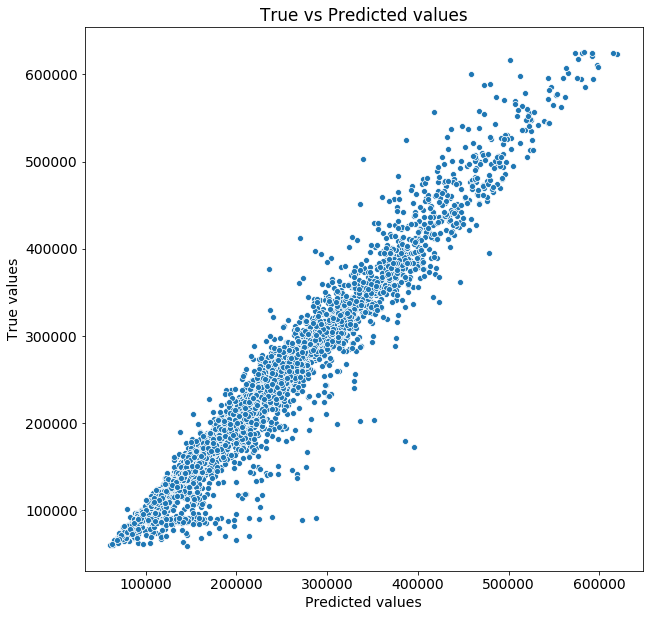

In [48]:
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.696
MAE:	30823.646
MSE:	2652016303.328


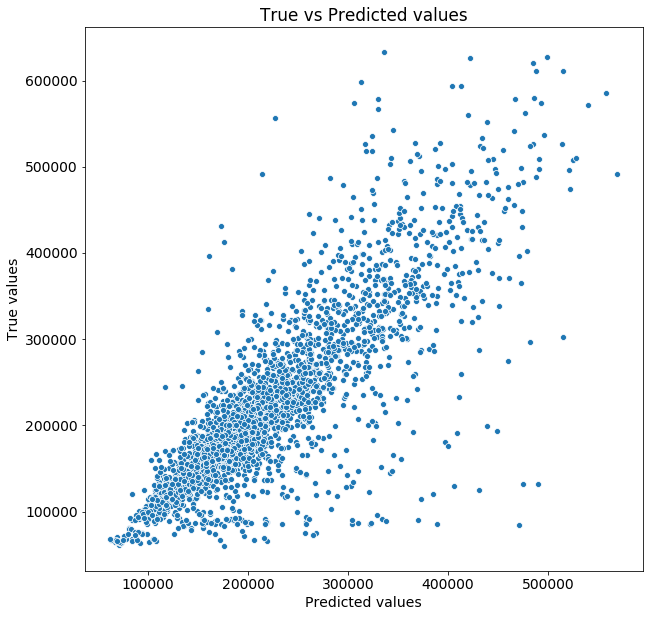

In [49]:
y_valid_preds = rf_model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

**Gradient Boosting**

In [50]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

R2:	0.764
MAE:	29390.374
MSE:	2026593171.721


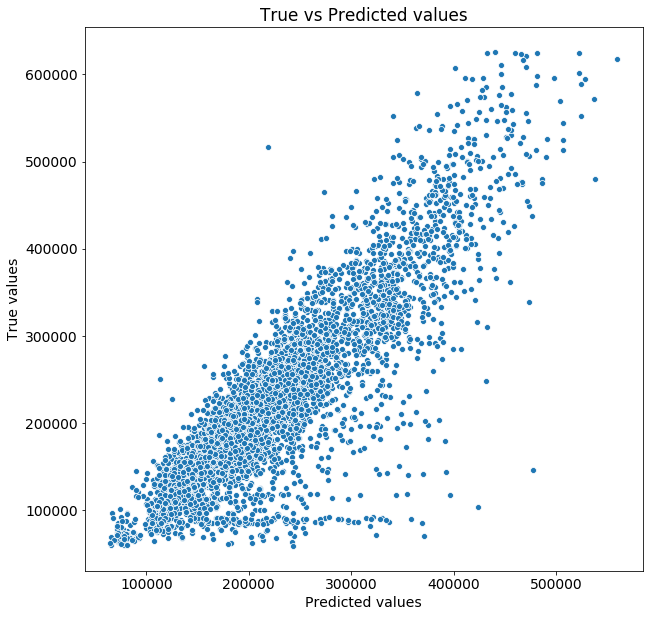

In [51]:
y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.697
MAE:	32372.534
MSE:	2639858612.391


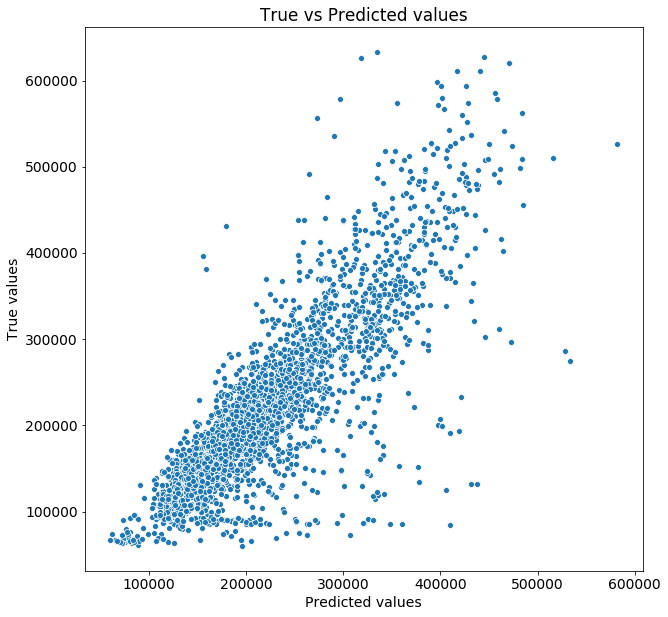

In [52]:
y_valid_preds = gb_model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

### Настройка и оценка финальной модели

**Подбор гиперпараметров**

In [53]:
gb_model = RandomForestRegressor(random_state=21)
gb_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=None, oob_score=False, random_state=21, verbose=0,
                      warm_start=False)

In [57]:
params = {'n_estimators':[100, 200, 300], 
          'max_depth':[10, 15, 18]}

gs = GridSearchCV(gb_model, params, scoring='r2', cv=KFold(n_splits=3, random_state=21, shuffle=True), n_jobs=-1)
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=21,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,


In [58]:
gs.best_params_

{'max_depth': 18, 'n_estimators': 300}

In [59]:
gs.best_score_

0.7304837792186161

**Обучение и оценка модели**

In [60]:
final_model = RandomForestRegressor(n_estimators=300, max_depth=18, random_state=21, max_features=7)
final_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=18,
                      max_features=7, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=21, verbose=0,
                      warm_start=False)

R2:	0.955
MAE:	12480.628
MSE:	383890157.917


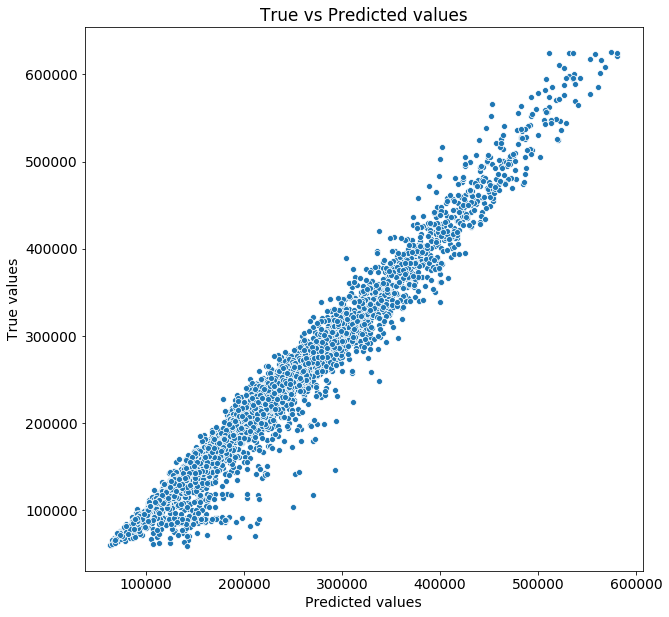

In [61]:
y_train_preds = final_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.735
MAE:	28510.028
MSE:	2311421847.502


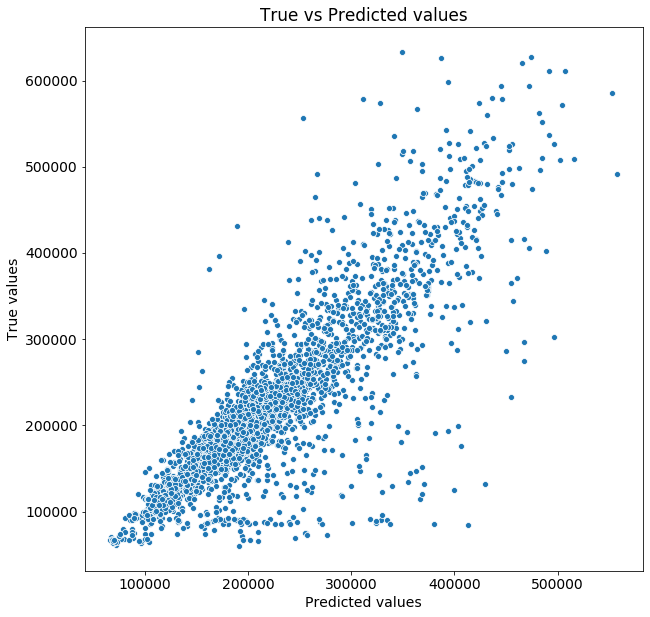

In [62]:
y_valid_preds = final_model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

**Важность признаков**

In [63]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.260437
1,Rooms,0.146793
10,Social_2,0.084849
9,Social_1,0.078301
3,LifeSquare,0.075467
11,Social_3,0.058732
0,DistrictId,0.052448
8,Ecology_1,0.040089
4,KitchenSquare,0.039739
7,HouseYear,0.039665


**Отбираем признаки для тестового датасета**

In [64]:
test_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']

In [65]:
feature_names = ['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
  'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1'
  ]


In [66]:
feature_names_for_stand = test_df[feature_names].select_dtypes(include='float64').columns.tolist()
feature_names_for_stand

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'HouseFloor',
 'Ecology_1',
 'Healthcare_1']

In [67]:
prepare_data(test_df) # в тестовом датасете очищаем данные

**Стандартизация данных**

In [68]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(test_df[feature_names_for_stand])

In [69]:
test_df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [70]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,0.106489,-0.380453,-0.180146,-0.610413,6,0.167688,1972,1.585280,B,B,11,2748,1,-0.168811,0,0,B
1,15856,74,0.106489,0.521242,-0.214688,-0.610413,6,-1.842216,1977,-0.367283,B,B,6,1437,3,-0.168811,0,2,B
2,5480,190,-1.087339,-1.712767,-1.369720,2.170933,2,-1.223784,1909,-0.998468,B,B,30,7538,87,4.791278,5,5,B
3,15664,47,0.106489,0.697268,1.079063,0.780260,22,1.404552,2007,-0.149940,B,B,23,4583,3,-0.168811,3,3,B
4,14275,27,-1.087339,-0.490046,0.497135,-0.610413,17,0.631512,2017,-0.397445,B,B,2,629,1,-0.168811,0,0,A


**Предсказываем цены для тестовых данных и выгружаем в файл**

In [71]:
test_df['Price'] = final_model.predict(test_df[feature_names])

In [72]:
test_df[['Id', 'Price']].to_csv('AGrishina_predictions.csv', index=False)